Author: Zhewei Yao <https://github.com/yaozhewei>, Amir Gholami <http://amirgholami.org/>_


This tutorial shows how to use AdaHessian https://github.com/amirgholami/adahessian, for machine learning problems, and also analyze AdaHessian for a 2D problem using the repo https://github.com/githubharald/analyze_ada_hessian

# We will begin with the analysis
We thank Harald Scheidl a lot for creating this analysis and good visulization: https://github.com/githubharald/analyze_ada_hessian

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import argparse

from ada_hessian import AdaHessian
from plot import plot_path, plot_function, show_plot
from optimize import optimize

In [24]:
def make_func(s):
    "parse the passed function string"
    def func(v):
        return eval(s)
    return func

In [25]:
class parser():
    def __init__(self):
        self.func = None
        self.num_iter = 10 
        self.start = (1., 1.)
        self.window = (-2., 2., -2., 2.)
        self.lr = 0.1 
        self.beta_g = 0.5
        self.beta_h = 0.5 
        self.hessian_pow = 1.
        self.num_samples = 1
        

## for simple quadratic function: 
$$f(x, y) = x^2 + 5y^2$$

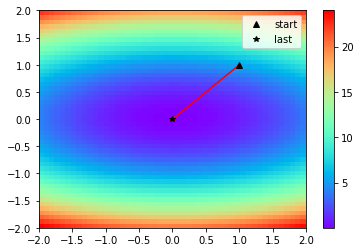

In [26]:
parsed = parser()

parsed.func = "v[0]**2+5*v[1]**2"
parsed.lr = 1.
parsed.beta_g = 0
parsed.beta_h = 0


func = make_func(parsed.func)

# optimize 2d parameter vector v of function
path = optimize(func, parsed.start, parsed.num_iter, parsed.lr, parsed.beta_g, parsed.beta_h, parsed.hessian_pow, parsed.num_samples)

# plot function and steps of optimizer
plot_function(func, parsed.window)
plot_path(path)
show_plot()


## for simple quadratic function with off diagonal element: 
$$f(x, y) = x^2 + 5y^2 + xy$$

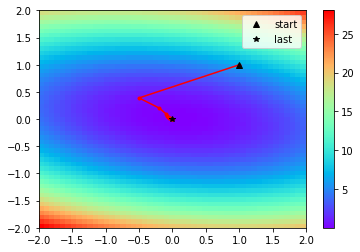

In [27]:
parsed = parser()

parsed.func = "v[0]**2+5*v[1]**2+v[0]*v[1]"
parsed.lr = .5
parsed.beta_g = 0.
parsed.beta_h = 0.


func = make_func(parsed.func)

# optimize 2d parameter vector v of function
path = optimize(func, parsed.start, parsed.num_iter, parsed.lr, parsed.beta_g, parsed.beta_h, parsed.hessian_pow, parsed.num_samples)

# plot function and steps of optimizer
plot_function(func, parsed.window)
plot_path(path)
show_plot()


## Simple quadratic function with simulated noise
$$f(x, y) = x^2 + 5y^2 + xy + \frac{1}{2}sin(5*x)^2 + \frac{1}{2}sin(5*y)^2$$

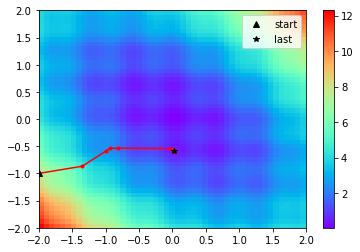

In [28]:
parsed = parser()

# without momentum
parsed.func = "v[0]**2+v[1]**2+v[0]*v[1]+0.5*torch.sum(torch.sin(5*v)**2)"
parsed.lr = 1
parsed.start = (-2, -1)
parsed.num_iter = 30
parsed.beta_g = 0.
parsed.beta_h = 0.


func = make_func(parsed.func)

# optimize 2d parameter vector v of function
path = optimize(func, parsed.start, parsed.num_iter, parsed.lr, parsed.beta_g, parsed.beta_h, parsed.hessian_pow, parsed.num_samples)

# plot function and steps of optimizer
plot_function(func, parsed.window)
plot_path(path)
show_plot()


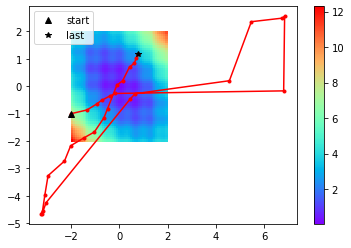

In [29]:
parsed = parser()

# with only gradient momentum
parsed.func = "v[0]**2+v[1]**2+v[0]*v[1]+0.5*torch.sum(torch.sin(5*v)**2)"
parsed.lr = 1
parsed.start = (-2, -1)
parsed.num_iter = 30
parsed.beta_g = 0.9
parsed.beta_h = 0.


func = make_func(parsed.func)

# optimize 2d parameter vector v of function
path = optimize(func, parsed.start, parsed.num_iter, parsed.lr, parsed.beta_g, parsed.beta_h, parsed.hessian_pow, parsed.num_samples)

# plot function and steps of optimizer
plot_function(func, parsed.window)
plot_path(path)
show_plot()


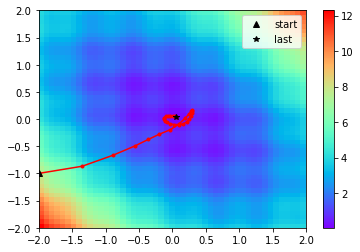

In [30]:
parsed = parser()

# with both first/second momentum
parsed.func = "v[0]**2+v[1]**2+v[0]*v[1]+0.5*torch.sum(torch.sin(5*v)**2)"
parsed.lr = 1
parsed.start = (-2, -1)
parsed.num_iter = 30
parsed.beta_g = 0.9
parsed.beta_h = 0.9


func = make_func(parsed.func)

# optimize 2d parameter vector v of function
path = optimize(func, parsed.start, parsed.num_iter, parsed.lr, parsed.beta_g, parsed.beta_h, parsed.hessian_pow, parsed.num_samples)

# plot function and steps of optimizer
plot_function(func, parsed.window)
plot_path(path)
show_plot()


# AdaHessian code explaination: https://github.com/amirgholami/adahessian/tree/master/instruction

In [34]:
class Adahessian(torch.optim.Optimizer):
    """Implements Adahessian algorithm.
    It has been proposed in `ADAHESSIAN: An Adaptive Second OrderOptimizer for Machine Learning`.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 0.15)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-4)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        hessian_power (float, optional): Hessian power (default: 1)
    """

    def __init__(self, params, lr=0.15, betas=(0.9, 0.999), eps=1e-4,
                 weight_decay=0, block_length=1, hessian_power=1):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(
                "Invalid beta parameter at index 0: {}".format(
                    betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(
                "Invalid beta parameter at index 1: {}".format(
                    betas[1]))
        if not 0.0 <= hessian_power <= 1.0:
            raise ValueError("Invalid Hessian power value: {}".format(hessian_power))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, hessian_power=hessian_power)

        super(Adahessian, self).__init__(params, defaults)

        self.block_length = block_length

    def get_trace(self, gradsH):
        """
        compute the Hessian vector product with a random vector v, at the current gradient point,
        i.e., compute the gradient of <gradsH,v>.
        :param gradsH: a list of torch variables
        :return: a list of torch tensors
        """

        params = self.param_groups[0]['params']

        v = [torch.randint_like(p, high=2, device='cuda') for p in params]
        for v_i in v:
            v_i[v_i == 0] = -1
        hvs = torch.autograd.grad(
            gradsH,
            params,
            grad_outputs=v,
            only_inputs=True,
            retain_graph=True)

        hutchinson_trace = []
        for hv, vi in zip(hvs, v):
            param_size = hv.size()
            if len(param_size) <= 1:  
                # For 1D tensor, e.g.,, bias, BatchNorm, LayerNorm etc.
                # Usually, you do not need to set spatial aveging for it, i.e., Hessian diagonal block size is 1 here.
                tmp_output = torch.abs(hv * vi)
                hutchinson_trace.append(tmp_output)

                # Of course, you can also use the same way as 2D tensor does to average your 1D tensor. 
                # tmp_output1 = torch.abs((hv * vi + 0.)).view(-1, self.block_length) # faltten to the N times self.block_length
                # tmp_output2 = torch.abs(torch.sum(tmp_output1, dim=[1])).view(-1) / float(self.block_length)
                # tmp_output3 = tmp_output2.repeat_interleave(self.block_length).view(param_size)
                # hutchinson_trace.append(tmp_output3)

            elif len(param_size) == 2: 
                # For 2D tensor, e.g., the matrix in the fully-connected layer.
                # This is a normal case for MLP, Transformer models. 
                # Usually, a spatial averaging needs to be used here to get the best result.
                # If you are not looking for the absolute best config, you may set it to be 1.
                # In all of our experiments, we sill get pretty good performance.
                tmp_output1 = torch.abs((hv * vi + 0.)).view(-1, self.block_length) # faltten to the N times self.block_length
                tmp_output2 = torch.abs(torch.sum(tmp_output1, dim=[1])).view(-1) / float(self.block_length)
                tmp_output3 = tmp_output2.repeat_interleave(self.block_length).view(param_size)
                hutchinson_trace.append(tmp_output3)
            elif len(param_size) == 3:
                # For 3D tensor, e.g., the 1D Conv layer.
                # This layer is usually used for Char-LM.

                # First Way:
                # Usually, you can set it to be the conv kernel size: in more details, for instance, your input/output channels are 20 and your kernel size is 5, 
                # then the 1D Conv kernel is in size 20x20x5, you can average along the final dim, i.e., the block_length = 5
                tmp_output = torch.abs(torch.sum(torch.abs(
                    hv * vi), dim=[2], keepdim=True)) / vi[0, 1].numel() # torch.sum() reduces the dim 2， i.e. the size 5

                # Second way:
                # Of course, you can also use the same self.block_length to average the spatival Hessian of 3D kernel.
                # tmp_output1 = torch.abs((hv * vi + 0.)).view(-1, self.block_length) # faltten to the N times self.block_length
                # tmp_output2 = torch.abs(torch.sum(tmp_output1, dim=[1])).view(-1) / float(self.block_length)
                # tmp_output3 = tmp_output2.repeat_interleave(self.block_length).view(param_size)
                # hutchinson_trace.append(tmp_output3)

            elif len(param_size) == 4:  
                # For 4D tensor, e.g, the 2D Conv layer
                # This layer is usually used for CV tasks.
                
                # First Way:
                # Usually, you can set it to be the conv kernel size: in more details, for instance, your input/output channels are 256 and your kernel size is 3x3, 
                # then the 2D Conv kernel is in size 20x20x3x3, you can average along the last two dims, , i.e., the block_length = 9
                tmp_output = torch.abs(torch.sum(torch.abs(
                    hv * vi), dim=[2, 3], keepdim=True)) / vi[0, 1].numel() # torch.sum() reduces the dim 2/3.
                hutchinson_trace.append(tmp_output)

                # Second way:
                # Of course, you can also use the same self.block_length to average the spatival Hessian of 4D kernel.
                # tmp_output1 = torch.abs((hv * vi + 0.)).view(-1, self.block_length) # faltten to the N times self.block_length
                # tmp_output2 = torch.abs(torch.sum(tmp_output1, dim=[1])).view(-1) / float(self.block_length)
                # tmp_output3 = tmp_output2.repeat_interleave(self.block_length).view(param_size)
                # hutchinson_trace.append(tmp_output3)
        
        return hutchinson_trace

    def step(self, gradsH, closure=None):
        """Performs a single optimization step.
        Arguments:
            gradsH: The gradient used to compute Hessian vector product.
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        # get the Hessian diagonal
        hut_trace = self.get_trace(gradsH)

        for group in self.param_groups:
            for i, p in enumerate(group['params']):
                if p.grad is None:
                    continue

                grad = deepcopy(gradsH[i].data)
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of Hessian diagonal square values
                    state['exp_hessian_diag_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_hessian_diag_sq = state['exp_avg'], state['exp_hessian_diag_sq']

                beta1, beta2 = group['betas']

                state['step'] += 1

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_hessian_diag_sq.mul_(beta2).addcmul_(
                    1 - beta2, hut_trace[i], hut_trace[i])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                # make the square root, and the Hessian power
                k = group['hessian_power']
                denom = (
                    (exp_hessian_diag_sq.sqrt() ** k) /
                    math.sqrt(bias_correction2) ** k).add_(
                    group['eps'])

                # make update
                p.data = p.data - \
                    group['lr'] * (exp_avg / bias_correction1 / denom + group['weight_decay'] * p.data)

        return loss